In [1]:
import numpy as np
import pandas as pd
import sklearn.neighbors
import sklearn.model_selection
import sklearn.datasets
import sklearn.manifold
import sklearn.decomposition

In [2]:
def score_embedding(data, labels, k=10, n_neighbors=5, random_state=42):
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    cv = sklearn.model_selection.StratifiedKFold(n_splits=k, random_state=random_state)
    return sklearn.model_selection.cross_val_score(model, data, labels, cv=cv)

In [3]:
def compare_embeddings(embeddings, n_neighbors=5, k=10, random_state=42):
    cross_val_scores = {}
    for alg in embeddings.keys():
        cross_val_scores[alg] = score_embedding(embeddings[alg][['x', 'y']].values, 
                                                embeddings[alg]['labels'].values,
                                                n_neighbors=n_neighbors,
                                                k=k,
                                                random_state=random_state)
    return pd.DataFrame(cross_val_scores).assign(n_neighbors=n_neighbors)

In [4]:
digits = sklearn.datasets.load_digits()

pendigits = {}
pendigits['tsne'] = pd.read_csv('embedding_pendigits_tsne1.csv', index_col=0)
pendigits['umap'] = pd.read_csv('embedding_pendigits_umap1.csv', index_col=0)
pendigits['lvis'] = pd.read_csv('embedding_pendigits_largevis1.csv', index_col=0)
pendigits['fits'] = pd.read_csv('embedding_pendigits_fitsne1.csv', index_col=0)

pendigits['leig'] = pd.DataFrame(
    sklearn.manifold.SpectralEmbedding(n_components=2).fit_transform(digits.data), 
    columns=('x', 'y')).assign(labels=digits.target)
pendigits['pca'] = pd.DataFrame(
    sklearn.decomposition.PCA(n_components=2).fit_transform(digits.data), 
    columns=('x', 'y')).assign(labels=digits.target)

In [5]:
df = pd.concat(compare_embeddings(pendigits, n_neighbors=n) for n in (10,20,40,80,160))

In [6]:
df.groupby('n_neighbors', ).mean()

,tsne,umap,lvis,fits,leig,pca
n_neighbors,,,,,,
10,0.976742,0.972930,0.965704,0.972896,0.777790,0.621706
20,0.973383,0.976201,0.973416,0.973395,0.777803,0.632835
40,0.955583,0.953891,0.952252,0.958920,0.777756,0.635647
80,0.947783,0.950570,0.945017,0.949431,0.768924,0.643402
160,0.948888,0.950570,0.920763,0.948863,0.746717,0.629027


In [7]:
df.groupby('n_neighbors', ).std() * 2

,tsne,umap,lvis,fits,leig,pca
n_neighbors,,,,,,
10,0.033481,0.043622,0.053206,0.041183,0.112792,0.091971
20,0.033307,0.035008,0.043507,0.036275,0.115692,0.081554
40,0.064360,0.059832,0.065633,0.057385,0.111581,0.077832
80,0.060277,0.056849,0.071807,0.054461,0.111257,0.085330
160,0.064613,0.056849,0.084504,0.054342,0.107641,0.106570


In [8]:
import seaborn as sns
sns.set()

In [9]:
tidy_df = df.reset_index().melt(id_vars=['index', 'n_neighbors'], 
                                value_vars=['fits', 'leig', 'lvis', 'pca', 'tsne', 'umap'])
tidy_df = tidy_df.rename(columns={'index':'fold', 'variable':'algorithm'})
tidy_df = tidy_df[tidy_df.algorithm != 'fits']

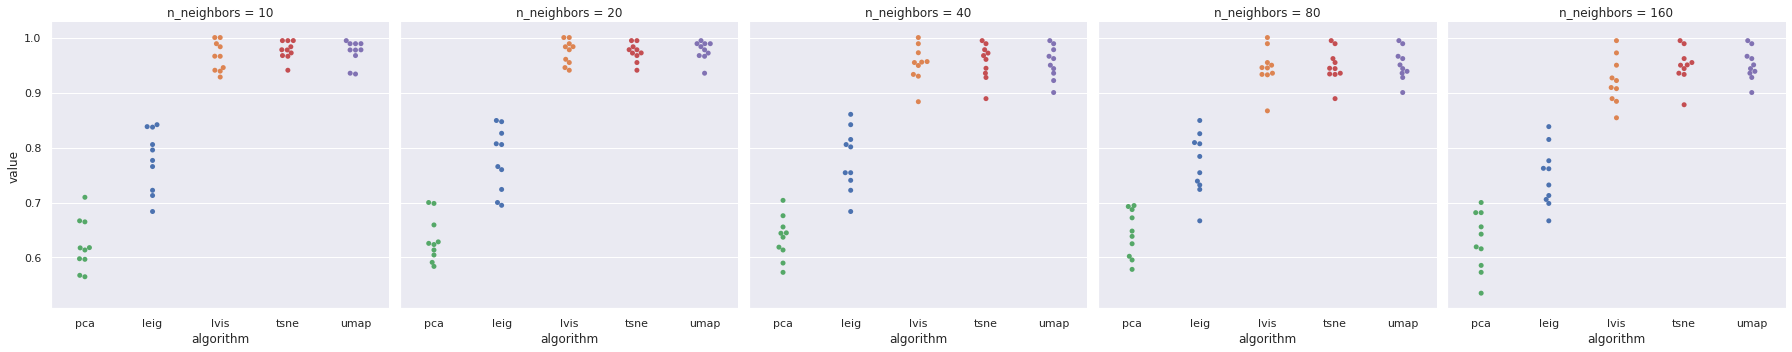

In [11]:
sns.catplot(x='algorithm', 
            y='value', 
            hue='algorithm', 
            kind='swarm', 
            col='n_neighbors',
            order=['pca', 'leig', 'lvis', 'tsne', 'umap'],
            data=tidy_df)